In [1]:

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard ML Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Deep learning utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Torch data manipulation
import torchvision
from torchvision import transforms
import albumentations as A

# Metrics
import torchmetrics as tm

# GeoTIFF image
import rasterio as rio
from rasterio.plot import show

2. CONFIG

In [2]:
# Set device variable
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

# Random control
RANDOM_SEED = 42

# Main path
MAIN_PATH = 'C://Users//vishal-sharma//Downloads//archive (2)//AMAZON//AMAZON'

3. Data preparation

In [3]:
def prepare_path_lists(main_path: str,
                      data_name: str):

    image_list = []
    mask_list = []
    mask_paths = []
    
    # List of possible mask dirs
    for option in ['label', 'mask', 'masks']:
        mask_paths.append(os.path.join(data_name, option))
    
    # Image dir
    image_path = os.path.join(data_name, 'image')
    
    # Loop throught all files to get proper lists
    for root, dirs, files in os.walk(main_path):
        for file in files:
            full_path = os.path.join(root, file)
            if image_path in full_path and full_path.endswith('.tif'):
                image_list.append(full_path)
            elif any(mask in full_path for mask in mask_paths) and full_path.endswith('.tif'):
                mask_list.append(full_path)
                
    return image_list, mask_list

In [4]:
# Training data
training_image_list, training_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Training')

# Test data
test_image_list, test_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Test')

# Validation data
val_image_list, val_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Validation')

In [5]:
train_df = pd.DataFrame(list(zip(training_image_list, training_mask_list)), 
                        columns=['image_path', 'mask_path'])

test_df = pd.DataFrame(list(zip(test_image_list, test_mask_list)), 
                        columns=['image_path', 'mask_path'])

val_df = pd.DataFrame(list(zip(val_image_list, val_mask_list)), 
                        columns=['image_path', 'mask_path'])

print(f'Training data contains: {len(train_df)} files')
print(f'Test data contains: {len(test_df)} files')
print(f'Validation data contains: {len(val_df)} files')

Training data contains: 499 files
Test data contains: 20 files
Validation data contains: 100 files


4. Helper functions

In [6]:
def calculate_tiff_statistics(df: pd.DataFrame, 
                              band_config: list = None):
    """
    Tiff images statistics used for normalization - MEAN and STD
    """
    
    image_paths = df['image_path']
    total_mean = 0
    total_std = 0
    
    for path in image_paths:
        if band_config is not None:
            img = rio.open(path).read(band_config)
        else:
            img = rio.open(path).read()
        total_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
        total_std += img.reshape((img.shape[0], -1)).std(axis=1)
        
    average_mean = total_mean / len(image_paths)
    average_std = total_std / len(image_paths)
    
    return np.round(average_mean, 1), np.round(average_std, 1)

def get_training_transformation():
    train_transform = [A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                      ]
    return A.Compose(train_transform, 
                     additional_targets={'rgb_image': 'image'}, 
                     is_check_shapes=False)
def normalize_image():
    normalize = [
        transforms.Normalize(mean=mean, std=std)
    ]
    return transforms.Compose(normalize)

def normalize_rgb(x: np.array):
    """
    Normalize a list of sample image data in the range of 0 to 1
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

def visualize_batch(batch: tuple):
    """
    Visualize batch from DataLoader - Original RGB image and Ground truth mask
    """
    images, masks, rgb_images = batch
    
    for index in range(0, len(images)):
        plt.figure(figsize=(18,10))
        mask = masks[index]
        rgb_image = rgb_images[index]
        rgb_image = rgb_image.numpy()
        plt.subplot(1, 2, 1)
        plt.imshow(mask)
        plt.subplot(1, 2, 2)
        show(normalize_rgb(rgb_image))
    plt.show()
    
def plot_statistics(**statistic_lists):
    """
    Visualize provided statistics in a row with correlated name.
    Provide the argument in keyword args format: statistic_name = List[statistics]
    For example: Loss_statistic = [train_loss, test_loss]
    """    
    for index, (name, statistic_list) in enumerate(statistic_lists.items()):
        plt.figure(figsize=(12,8))
        label_name = name.split(' ')[0]
        plt.plot(statistic_list[0], label=f'Training {label_name}')
        plt.plot(statistic_list[1], label=f'Test {label_name}')
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.legend()  


5. Dataset class

In [7]:
class ForestSegmentationDataset(Dataset):
    def __init__(self,
                df: pd.DataFrame,
                band_config: list = None,
                transform: A.Compose = None,
                normalize: transforms.Compose = None):
        self.df = df
        self.band_config = band_config
        self.transform = transform
        self.normalize = normalize
    
    def __len__(self):
        return len(self.df)
    
    def __str__(self):
        return f'<ForestSegmentationDataset> with {len(self.df)} data'
    
    def __getitem__(self, index):
        with rio.open(self.df['image_path'].iloc[index]) as src:
            if self.band_config is not None:
                image = src.read(self.band_config, out_dtype='float32')
            else:
                image = src.read(out_dtype='float32')
            rgb_image = src.read([1,2,3], out_dtype='float32')
        
        with rio.open(self.df['mask_path'].iloc[index]) as src:
            mask = src.read(out_dtype='float32')
            mask = np.squeeze(mask)
        
        if self.transform:
            random.seed(RANDOM_SEED)
            transformed = self.transform(image=image, 
                                         mask=mask, 
                                         rgb_image=rgb_image)
            image = transformed['image']
            mask = transformed['mask']
            rgb_image = transformed['rgb_image']
        
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        if self.normalize:
            image = self.normalize(image)
        
        return image, mask, rgb_image

In [8]:
mean, std = calculate_tiff_statistics(df=train_df)

print(f'Training dataset MEAN statistic list: {mean}')
print(f'Training dataset STD statistic list: {std}')

Training dataset MEAN statistic list: [ 622.6  683.1  436.7 2952. ]
Training dataset STD statistic list: [380.9 276.5 246.8 554. ]


In [9]:
train_dataset = ForestSegmentationDataset(df=train_df,
                                         #transform=get_training_transformation(),
                                         normalize=normalize_image())

test_dataset = ForestSegmentationDataset(df=test_df,
                                         normalize=normalize_image())

In [10]:
train_dataloader = DataLoader(train_dataset,
                             batch_size=6,
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=6,
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

In [11]:
batch = next(iter(train_dataloader))
images, masks, rgb_images = batch
print(f'Batch images shape: {images.shape}')
print(f'Batch masks shape: {masks.shape}')
print(f'Batch rgb_images shape: {rgb_images.shape}')

Batch images shape: torch.Size([6, 4, 512, 512])
Batch masks shape: torch.Size([6, 512, 512])
Batch rgb_images shape: torch.Size([6, 3, 512, 512])


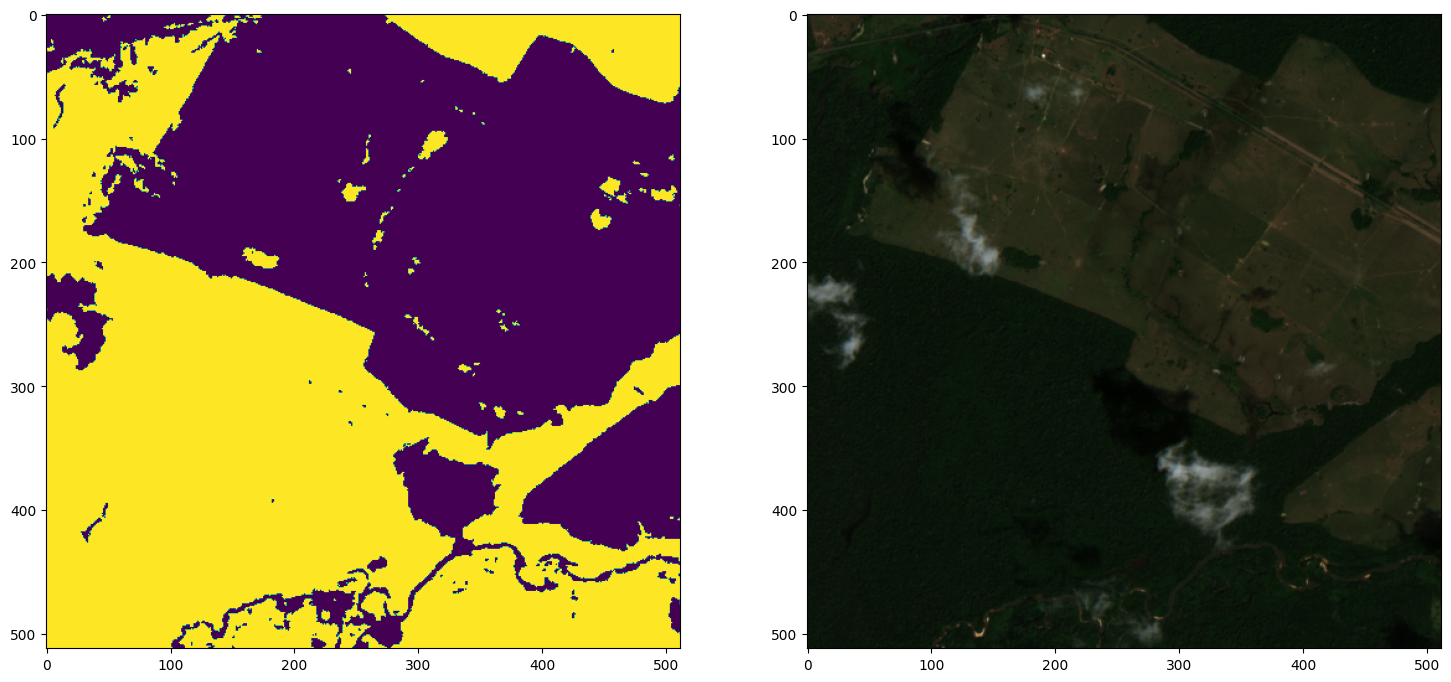

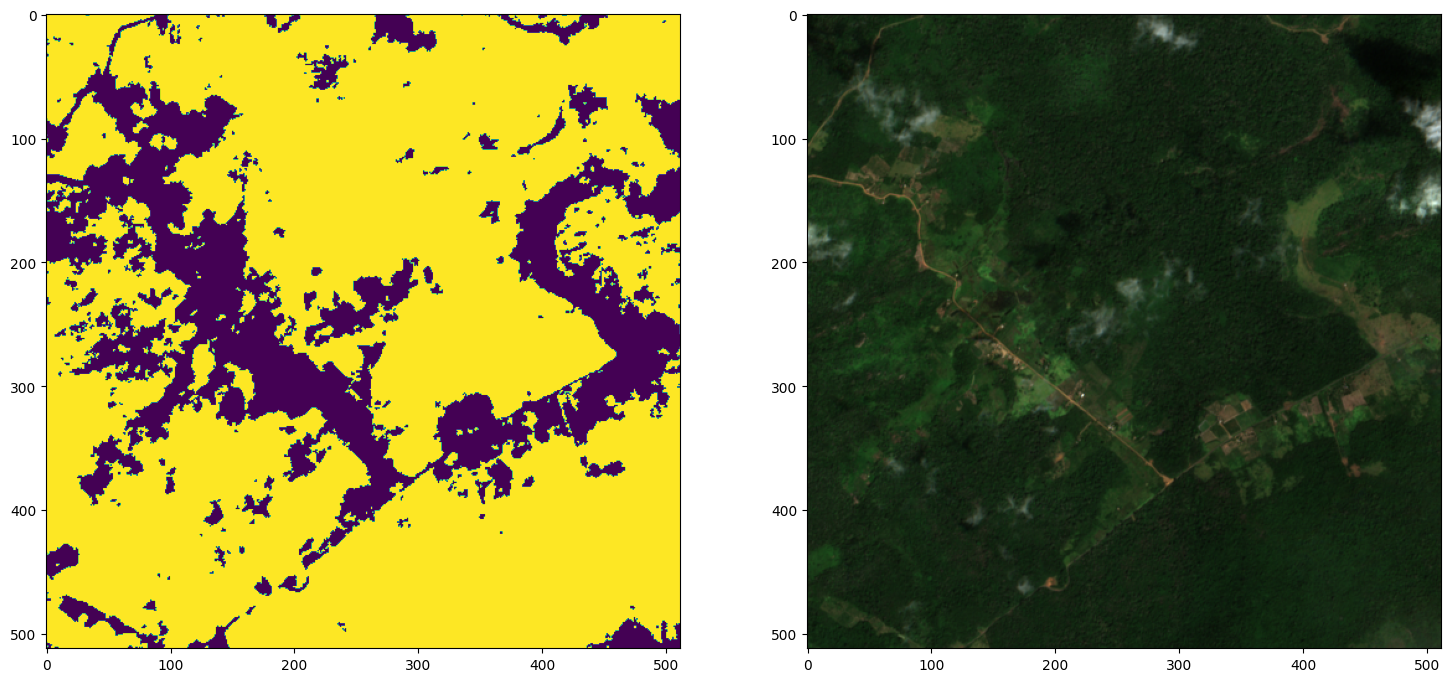

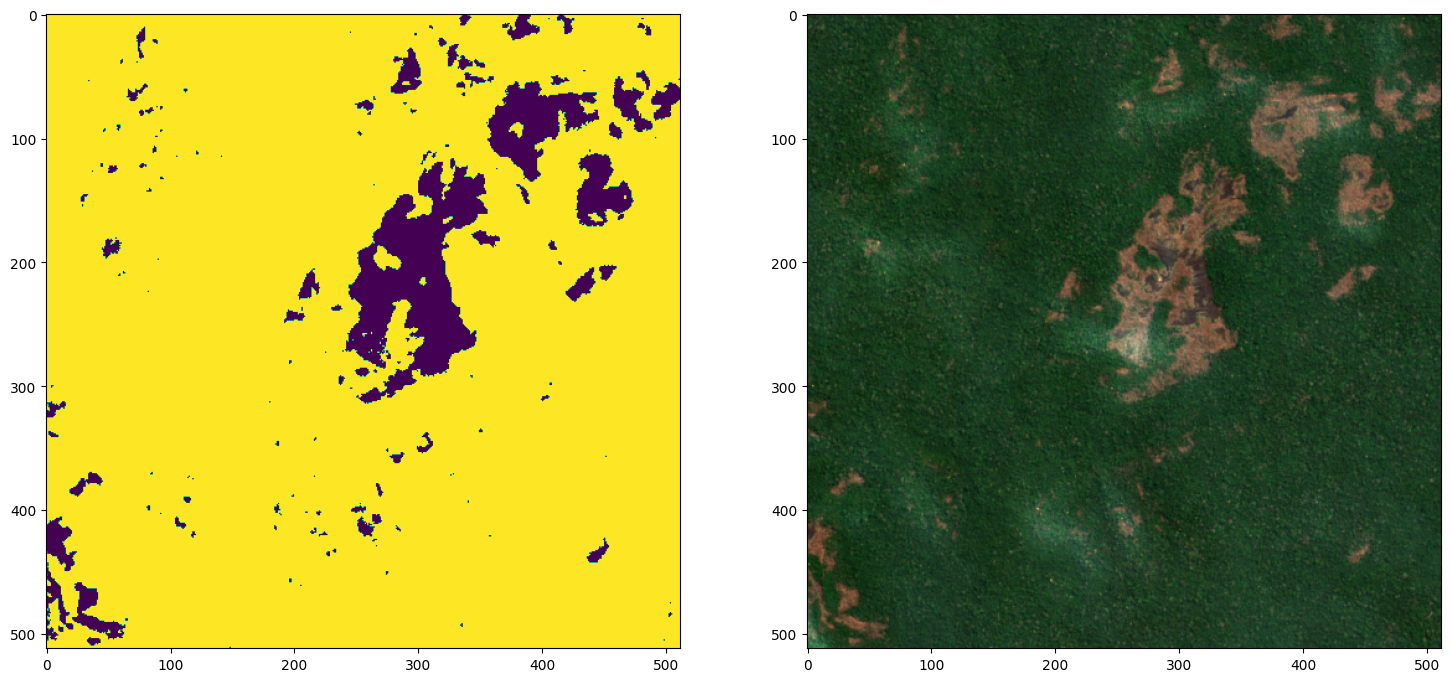

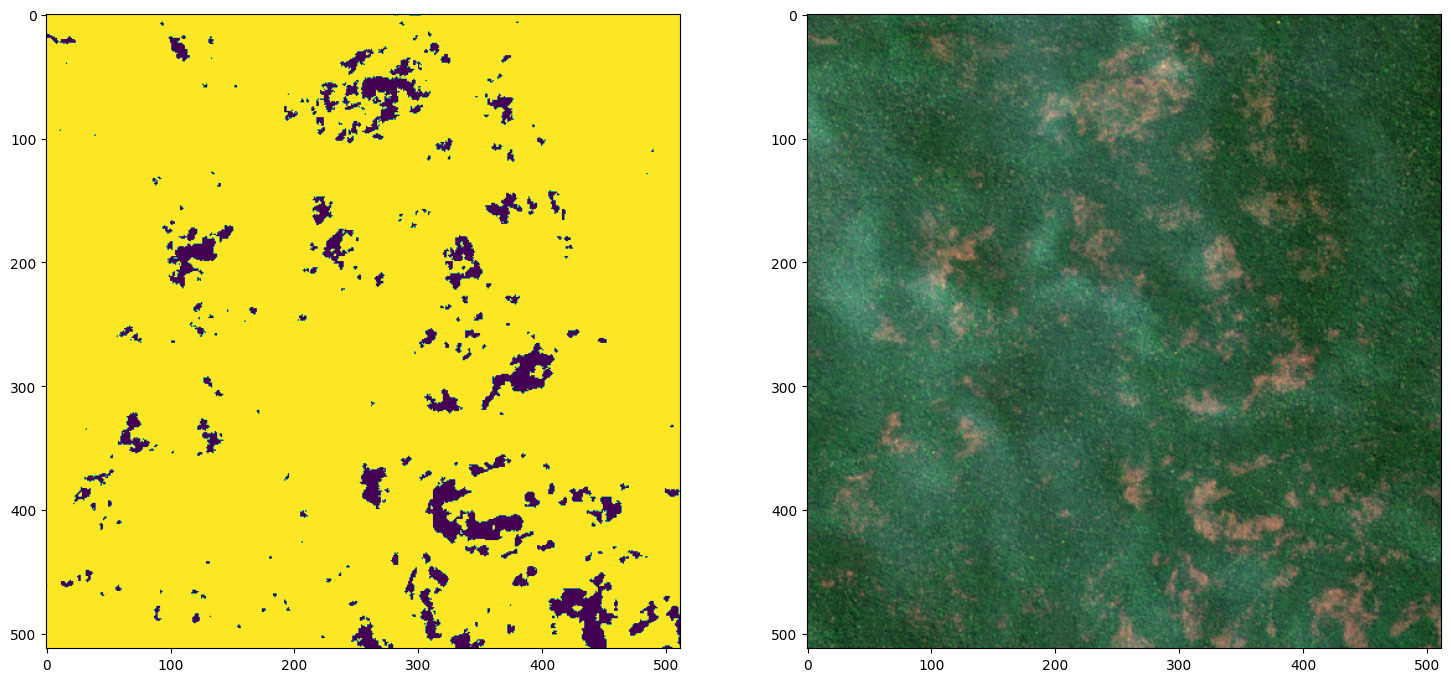

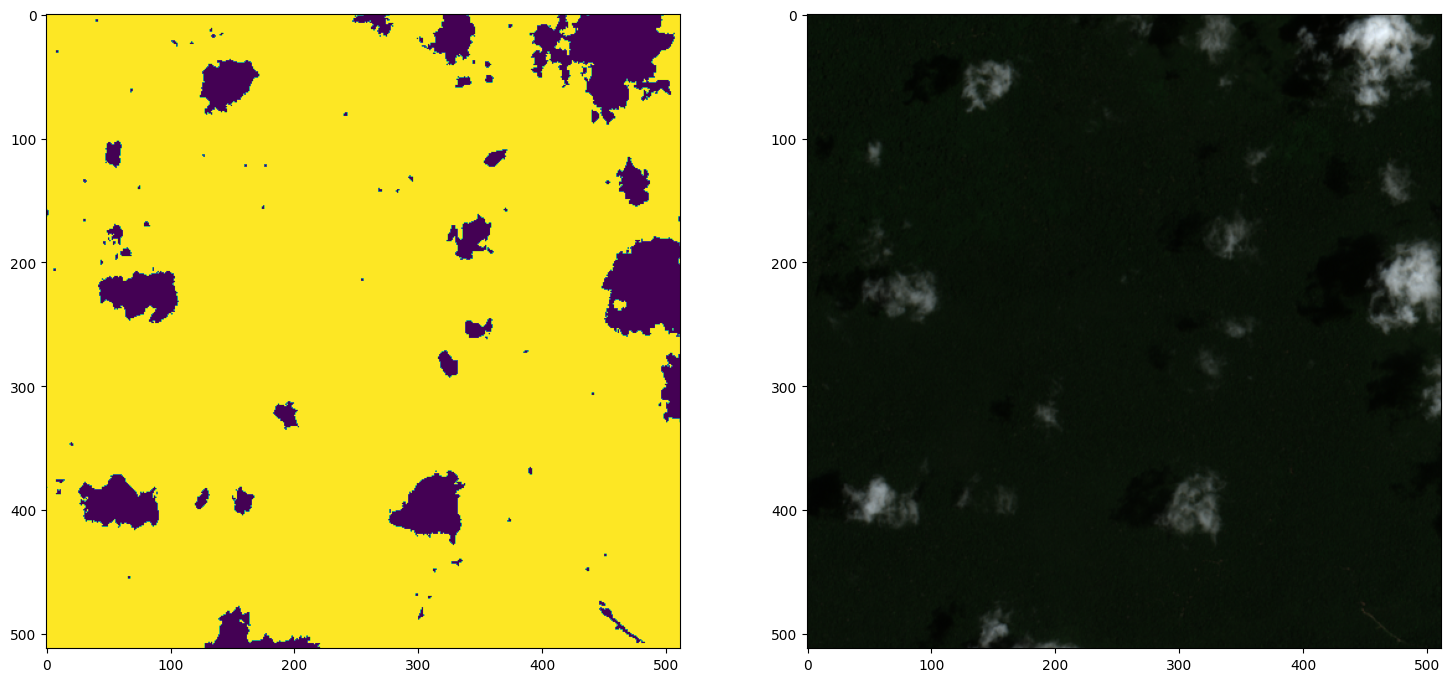

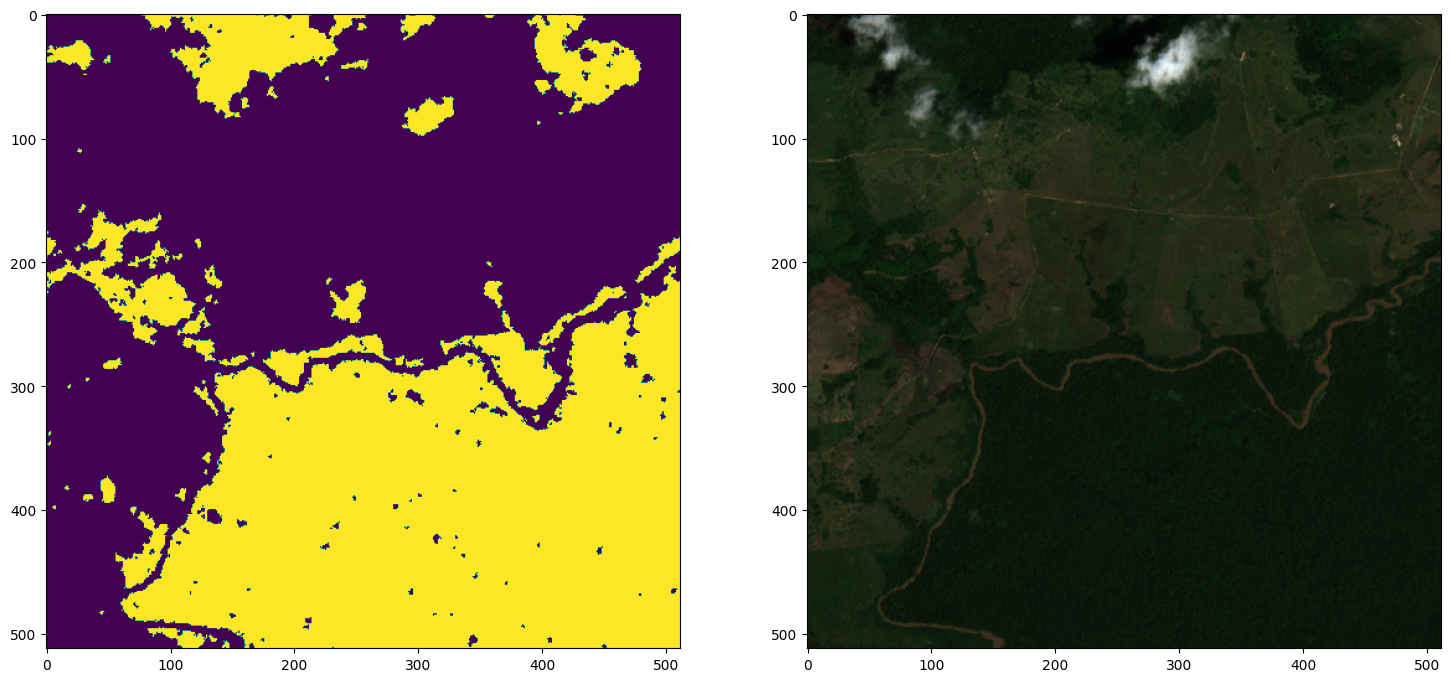

In [12]:
visualize_batch(batch=batch)

6. U-NET Model

In [13]:
def double_conv(input_channels, output_channels):
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(output_channels, output_channels, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True)
    )

def up_conv(input_channels, output_channels):
    return nn.Sequential(
      nn.ConvTranspose2d(input_channels, output_channels, kernel_size=(2,2), stride=2),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True)
  )
class ForestSegmentation(nn.Module):
    def __init__(self, encoder_channel, decoder_channel, input_channels, bottom_channels, class_number):
        super().__init__()
        self.encoder_channel = encoder_channel
        self.decoder_channel = decoder_channel
        self.bottom_channels = bottom_channels
        self.class_number = class_number

        self.encoder1 = double_conv(input_channels, encoder_channel[0])

        self.encoder2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[0], encoder_channel[1]))

        self.encoder3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[1], encoder_channel[2]))

        self.encoder4 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[2], encoder_channel[3]))

        self.bottleneck = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                        double_conv(encoder_channel[3], bottom_channels))

        self.decoder1up = up_conv(bottom_channels, bottom_channels)
        self.decoder1 = double_conv(encoder_channel[3]+bottom_channels, decoder_channel[0])

        self.decoder2up = up_conv(decoder_channel[0], decoder_channel[0])
        self.decoder2 = double_conv(encoder_channel[2]+decoder_channel[0], decoder_channel[1])

        self.decoder3up = up_conv(decoder_channel[1], decoder_channel[1])
        self.decoder3 = double_conv(encoder_channel[1]+decoder_channel[1], decoder_channel[2])

        self.decoder4up = up_conv(decoder_channel[2], decoder_channel[2])
        self.decoder4 = double_conv(encoder_channel[0]+decoder_channel[2], decoder_channel[3])

        self.classifier = nn.Conv2d(decoder_channel[3], class_number, kernel_size=(1,1))

    def forward(self, x):

        # Encoder
        encoder1 = self.encoder1(x)
        encoder2 = self.encoder2(encoder1)
        encoder3 = self.encoder3(encoder2)
        encoder4 = self.encoder4(encoder3)

        # Bottleneck
        x = self.bottleneck(encoder4)

        # Decoder
        x = self.decoder1up(x)
        x = torch.concat([x, encoder4], dim=1)
        x = self.decoder1(x)

        x = self.decoder2up(x)
        x = torch.concat([x, encoder3], dim=1)
        x = self.decoder2(x)

        x = self.decoder3up(x)
        x = torch.concat([x, encoder2], dim=1)
        x = self.decoder3(x)

        x = self.decoder4up(x)
        x = torch.concat([x, encoder1], dim=1)
        x = self.decoder4(x)

        # Classifier head
        x = self.classifier(x)

        return x

In [14]:
model = ForestSegmentation(encoder_channel=[16,32,64,128], 
                             decoder_channel=[128,64,32,16], 
                             input_channels=4, 
                             bottom_channels=256, 
                             class_number=2)

7. Model training

In [15]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [16]:
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

In [25]:
iou_score = tm.JaccardIndex('binary', num_classes=2).to(DEVICE)

In [22]:
import segmentation_models_pytorch as smp
import torch

# Assuming DEVICE is your device, e.g., 'cuda' for GPU or 'cpu' for CPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create a segmentation model (e.g., Unet with a specific backbone)
model = smp.Unet('resnet34', in_channels=3, classes=2)

# Assuming your segmentation output has 2 classes (binary segmentation)
iou_score = smp.metrics.IoU().to(DEVICE)


AttributeError: module 'segmentation_models_pytorch.metrics' has no attribute 'IoU'

In [19]:
import torch

print(torch.cuda.is_available())

False


In [28]:
epoch_number = []
train_iou_scores = []
train_loss_scores = []
test_iou_scores = []
test_loss_scores = []

def training_loop(n_epochs: int,
                  optimizer: torch.optim.Optimizer,
                  lr_scheduler: torch.optim.lr_scheduler,
                  model: nn.Module,
                  loss_fn: nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  validation_dataloader: torch.utils.data.DataLoader,
                  device: torch.device = DEVICE):
    
    model.to(device)

    for epoch in range(0, n_epochs):
        print(f'-----EPOCH: {epoch+1}/{n_epochs}-----')

        model.train()
        for (image, label, _) in train_dataloader:
            torch.cuda.empty_cache()
            image = image.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            prediction = model(image)
            prediction, max_indices = torch.max(prediction, dim=1)
            loss = loss_fn(prediction, label)

            training_iou = iou_score(prediction, label)

            loss.backward()
            optimizer.step()

        training_iou = iou_score.compute()

        print('************************************************')
        print(f"Train loss: {loss.item():.5f} | Train IoU_Score: {training_iou:.2f}")

        epoch_number.append(epoch)
        train_iou_scores.append(training_iou.detach().cpu().numpy())
        train_loss_scores.append(loss.item())
        
        iou_score.reset()
        
        model.eval()
        with torch.no_grad():
            for (image, label, _) in validation_dataloader:
                torch.cuda.empty_cache()
                image = image.to(device)
                label = label.to(device)
                prediction = model(image)
                prediction, max_indices = torch.max(prediction, dim=1)
                test_loss = loss_fn(prediction, label)

                test_iou = iou_score(prediction, label)

        test_iou = iou_score.compute()

        print(f"Test loss: {test_loss.item():.5f} | Test IoU_score: {test_iou:.2f}")
        print('************************************************')
        
        test_loss_scores.append(test_loss.item())
        
        test_iou_score_checker = test_iou.detach().cpu().numpy()
        
        #Append for the first epoch
        if epoch == 0:
            test_iou_scores.append(test_iou_score_checker)
            
        if test_iou_score_checker > max(test_iou_scores):
            torch.save(model.state_dict(), 'forest_segmentation_model.pt')
            print(f'[INFO] model saved for epoch: {epoch+1}')
        
        if epoch != 0:
            test_iou_scores.append(test_iou_score_checker)
            
        iou_score.reset()
        lr_scheduler.step()
        
    return

In [29]:
training_loop(n_epochs=20,
             optimizer=optimizer,
             lr_scheduler=scheduler,
             model=model,
             loss_fn=criterion,
             train_dataloader=train_dataloader,
             validation_dataloader=test_dataloader)

-----EPOCH: 1/20-----


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[6, 4, 512, 512] to have 3 channels, but got 4 channels instead